In [2]:
import pandas as pd
from mplsoccer import Sbopen, Pitch
import numpy as np
import math

In [3]:
parser = Sbopen()
df_match = parser.match(competition_id=37, season_id=42)
match_ids = df_match.match_id.unique()

In [4]:
all_events_df = []
for match_id in match_ids:
    events = parser.event(match_id)[0]
    # Filter for shot events that are free kicks
    free_kick_shots = events[(events['type_name'] == 'Shot') & (events['sub_type_name'] == 'Free Kick')]
    all_events_df.append(free_kick_shots)
df_shot = pd.concat(all_events_df, ignore_index=True)
df_shot.columns.tolist()

['id',
 'index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'duration',
 'match_id',
 'type_id',
 'type_name',
 'possession_team_id',
 'possession_team_name',
 'play_pattern_id',
 'play_pattern_name',
 'team_id',
 'team_name',
 'tactics_formation',
 'player_id',
 'player_name',
 'position_id',
 'position_name',
 'pass_recipient_id',
 'pass_recipient_name',
 'pass_length',
 'pass_angle',
 'pass_height_id',
 'pass_height_name',
 'end_x',
 'end_y',
 'sub_type_id',
 'sub_type_name',
 'body_part_id',
 'body_part_name',
 'x',
 'y',
 'under_pressure',
 'outcome_id',
 'outcome_name',
 'aerial_won',
 'counterpress',
 'out',
 'ball_recovery_recovery_failure',
 'pass_assisted_shot_id',
 'pass_shot_assist',
 'shot_statsbomb_xg',
 'end_z',
 'shot_key_pass_id',
 'technique_id',
 'technique_name',
 'goalkeeper_position_id',
 'goalkeeper_position_name',
 'pass_no_touch',
 'foul_committed_advantage',
 'foul_won_advantage',
 'pass_goal_assist',
 'foul_won_defensive',
 'pass_cut_back'

In [7]:
import pandas as pd
import numpy as np

# Assuming you're using StatsBomb's data parser
def extract_free_kicks(parser, competition_ids, season_ids):
    """
    Extract free kick shots from multiple competitions and seasons

    Parameters:
    parser - StatsBomb parser object
    competition_ids - list of competition IDs
    season_ids - list of season IDs for each competition (should match length of competition_ids)

    Returns:
    DataFrame with free kick data
    """
    all_free_kicks = []

    for comp_id, season_id in zip(competition_ids, season_ids):
        print(f"Processing competition {comp_id}, season {season_id}...")

        # Get all matches for this competition/season
        df_match = parser.match(competition_id=comp_id, season_id=season_id)
        match_ids = df_match.match_id.unique()

        for match_id in match_ids:
            try:
                # Get events for this match
                events = parser.event(match_id)[0]

                # Filter for shot events that are free kicks
                free_kick_shots = events[(events['type_name'] == 'Shot') &
                                        (events['sub_type_name'] == 'Free Kick')].copy()  # Create explicit copy

                # Add match and competition context
                if not free_kick_shots.empty:
                    match_info = df_match[df_match.match_id == match_id].iloc[0]
                    free_kick_shots.loc[:, 'competition_name'] = match_info['competition_name']
                    free_kick_shots.loc[:, 'season_name'] = match_info['season_name']
                    free_kick_shots.loc[:, 'home_team'] = match_info['home_team_name']
                    free_kick_shots.loc[:, 'away_team'] = match_info['away_team_name']

                    all_free_kicks.append(free_kick_shots)
            except Exception as e:
                print(f"Error processing match {match_id}: {e}")

    # Combine all free kicks into a single DataFrame
    if all_free_kicks:
        df_free_kicks = pd.concat(all_free_kicks, ignore_index=True)
        return df_free_kicks
    else:
        return pd.DataFrame()

def process_free_kick_data(df_free_kicks):
    """
    Process and clean free kick data
    """
    # Create a working copy to avoid warnings
    df = df_free_kicks.copy()

    # Create a binary target variable for goals
    df.loc[:, 'is_goal'] = df['outcome_name'].apply(lambda x: 1 if x == 'Goal' else 0)

    # Calculate shot angle and distance
    df.loc[:, 'shot_angle'] = df.apply(
        lambda row: calculate_angle(row['x'], row['y']), axis=1)

    df.loc[:, 'shot_distance'] = df.apply(
        lambda row: calculate_distance(row['x'], row['y']), axis=1)

    # Extract body part used for the shot as a feature
    df.loc[:, 'body_part'] = df['body_part_name']

    # Determine if the shot was on the left or right side of the field
    df.loc[:, 'side_of_field'] = df['y'].apply(
        lambda y: 'left' if y < 40 else ('right' if y > 40 else 'center'))

    # Determine shot technique
    df.loc[:, 'shot_technique'] = df['technique_name']

    # Extract time features
    df.loc[:, 'game_period'] = df['period']
    df.loc[:, 'game_minute'] = df['minute']

    # Select important columns for the CSV
    selected_columns = [
        # Identifiers and context
        'id', 'match_id', 'competition_name', 'season_name',



        # Shot details
        'x', 'y', 'shot_distance', 'shot_angle',
        'body_part', 'side_of_field',

        # Shot outcomes
        'is_goal', 'outcome_name', 'shot_statsbomb_xg',


    ]

    # Filter only existing columns (in case some are missing)
    existing_columns = [col for col in selected_columns if col in df.columns]

    return df[existing_columns]

# Define the angle and distance calculation functions
def calculate_angle(x, y):
    """Calculate the angle of the shot in degrees"""
    # 44 and 36 is the location of each goal post
    g0 = [120, 44]  # Right goal post
    p = [x, y]      # Shot position
    g1 = [120, 36]  # Left goal post
    v0 = np.array(g0) - np.array(p)
    v1 = np.array(g1) - np.array(p)
    angle = np.math.atan2(np.linalg.det([v0,v1]), np.dot(v0,v1))
    return abs(np.degrees(angle))

def calculate_distance(x, y):
    """Calculate the distance to goal in StatsBomb units"""
    x_dist = 120-x
    y_dist = 0
    if (y<36):
        y_dist = 36-y
    elif (y>44):
        y_dist = y-44
    return np.sqrt(x_dist**2 + y_dist**2)

# Main execution
def create_free_kick_dataset():
    # Initialize the StatsBomb parser
    parser = Sbopen()

    # Define competitions and seasons to include
    # Example: [(English Premier League, 2020/21), (La Liga, 2020/21), etc.]
    competitions_seasons = [
        (2, 44),    # Example: La Liga 2020/21
        (37, 42),   # Premier League 2019/20
        (43, 3),    # World Cup 2018
        # Add more competitions as needed
    ]

    competition_ids = [comp for comp, _ in competitions_seasons]
    season_ids = [season for _, season in competitions_seasons]

    # Extract free kick data
    free_kicks_df = extract_free_kicks(parser, competition_ids, season_ids)

    if not free_kicks_df.empty:
        # Process and clean the data
        processed_df = process_free_kick_data(free_kicks_df)

        # Save to CSV
        processed_df.to_csv('free_kicks_dataset.csv', index=False)
        print(f"Dataset created with {len(processed_df)} free kicks.")

        # Generate some summary statistics
        print("\nSummary Statistics:")
        goals = processed_df['is_goal'].sum()
        total = len(processed_df)
        print(f"Total free kicks: {total}")
        print(f"Goals: {goals} ({goals/total*100:.2f}%)")
        print(f"Average distance: {processed_df['shot_distance'].mean():.2f}")
        print(f"Average xG: {processed_df['shot_statsbomb_xg'].mean():.4f}")

        # Optional: create categorical distance and angle features
        processed_df.loc[:, 'distance_category'] = pd.cut(
            processed_df['shot_distance'],
            bins=[0, 20, 25, 30, 35, 100],
            labels=['Very Close', 'Close', 'Medium', 'Far', 'Very Far']
        )

        processed_df.loc[:, 'angle_category'] = pd.cut(
            processed_df['shot_angle'],
            bins=[0, 3, 6, 10, 15, 30],
            labels=['Terrible', 'Poor', 'Fair', 'Good', 'Great']
        )

        # Save enhanced version with categories
        processed_df.to_csv('free_kicks_dataset_enhanced.csv', index=False)

        return processed_df
    else:
        print("No free kick data found.")
        return None

# Execute if run as script
if __name__ == "__main__":
    create_free_kick_dataset()

Processing competition 2, season 44...
Processing competition 37, season 42...
Processing competition 43, season 3...
Dataset created with 235 free kicks.

Summary Statistics:
Total free kicks: 235
Goals: 18 (7.66%)
Average distance: 28.50
Average xG: 0.0373


C:\Users\ebrah\AppData\Local\Temp\ipykernel_53384\2683041362.py:116: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]), np.dot(v0,v1))


In [4]:
df_shot.columns.to_list()
df_goals = df_shot[df_shot.outcome_name == 'Goal'][['x', 'y', 'outcome_name', 'shot_statsbomb_xg']].copy()


df_non_goal_shots = df_shot[df_shot.outcome_name != 'Goal'][['x', 'y', 'outcome_name', 'shot_statsbomb_xg']].copy()
df_non_goal_shots['outcome_name'] = 'No Goal'

In [5]:
def calculate_angle(x, y):
  # 44 and 36 is the location of each goal post
  g0 = [120, 44]
  p = [x, y]
  g1 = [120, 36]

  v0 = np.array(g0) - np.array(p)
  v1 = np.array(g1) - np.array(p)

  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
  return(abs(np.degrees(angle)))

def calculate_distance(x, y):
  x_dist = 120-x
  y_dist = 0
  if (y<36):
    y_dist = 36-y
  elif (y>44):
    y_dist = y-44
  return math.sqrt(x_dist**2 + y_dist**2)

In [6]:
df_goals['distance'] = df_goals.apply(lambda row: calculate_distance(row['x'], row['y']), axis=1)
df_goals['angle'] = df_goals.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)

# Add distance and angle columns to df_non_goal_shots
df_non_goal_shots['distance'] = df_non_goal_shots.apply(lambda row: calculate_distance(row['x'], row['y']), axis=1)
df_non_goal_shots['angle'] = df_non_goal_shots.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)

C:\Users\ebrah\AppData\Local\Temp\ipykernel_9204\805757160.py:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
C:\Users\ebrah\AppData\Local\Temp\ipykernel_9204\805757160.py:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))


In [7]:
df = pd.concat([df_goals, df_non_goal_shots], axis=0)

# Reset index (optional)
df = df.reset_index(drop=True)
df


,x,y,outcome_name,shot_statsbomb_xg,distance,angle
0,93.6,75.6,Goal,0.005921,41.176692,6.186767
1,101.2,40.0,Goal,0.121448,18.800000,24.022957
2,97.6,51.2,Goal,0.074687,23.528706,16.340806
3,90.2,53.7,Goal,0.015563,31.338953,12.678364
4,100.5,26.2,Goal,0.068447,21.824069,15.708010
...,...,...,...,...,...,...
65,83.7,38.0,No Goal,0.012272,36.300000,12.539122
66,94.1,26.1,No Goal,0.041974,27.727604,13.730289
67,86.0,35.3,No Goal,0.020629,34.007205,13.173558
68,108.5,15.3,No Goal,0.008374,23.679949,7.218783


In [8]:
summary_stats = df.groupby('outcome_name')[['distance', 'angle']].mean().round(2)
print(summary_stats)

              distance  angle
outcome_name                 
Goal             27.17  15.24
No Goal          28.61  13.54


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Convert categorical outcome to binary (which you've already done)
df['label'] = df['outcome_name'].apply(lambda x: 1 if x == 'Goal' else 0)

# Feature selection - you can keep these or add more
features = ['distance', 'angle', 'shot_statsbomb_xg']
X = df[features]
y = df['label']

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42)

# Create and train the logistic regression model
# C parameter controls regularization strength (smaller = stronger regularization)
model = LogisticRegression(C=1.0, random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of being a goal
y_pred = model.predict(X_test)  # Binary prediction

# Evaluate the model
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get feature importance
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
})
print("\nFeature Importance:")
print(coefficients.sort_values('Coefficient', ascending=False))

# Cross-validation
cv_scores = cross_val_score(model, X_scaled_df, y, cv=5, scoring='roc_auc')
print(f"\nCross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean CV ROC AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))

# ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Confusion matrix visualization
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Goal', 'Goal'], yticklabels=['No Goal', 'Goal'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Feature importance
plt.subplot(2, 2, 3)
sns.barplot(x='Feature', y='Coefficient', data=coefficients.sort_values('Coefficient', ascending=False))
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()

# Prediction probability distribution
plt.subplot(2, 2, 4)
sns.histplot(data=pd.DataFrame({
    'Goal Probability': y_pred_proba,
    'Actual': y_test
}), x='Goal Probability', hue='Actual', bins=20, element='step')
plt.title('Prediction Probability Distribution')
plt.tight_layout()

plt.show()

# Create a table comparing actual goals vs xG
comparison_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'Probability': y_pred_proba,
    'StatsBomb xG': X_test['shot_statsbomb_xg'].reset_index(drop=True) if 'shot_statsbomb_xg' in X_test.columns else np.nan,
    'Distance': X_test['distance'].reset_index(drop=True),
    'Angle': X_test['angle'].reset_index(drop=True)
})

# Display first few rows
print("\nComparison of Actual vs Predicted:")
print(comparison_df.head(10))

NameError: name 'df' is not defined

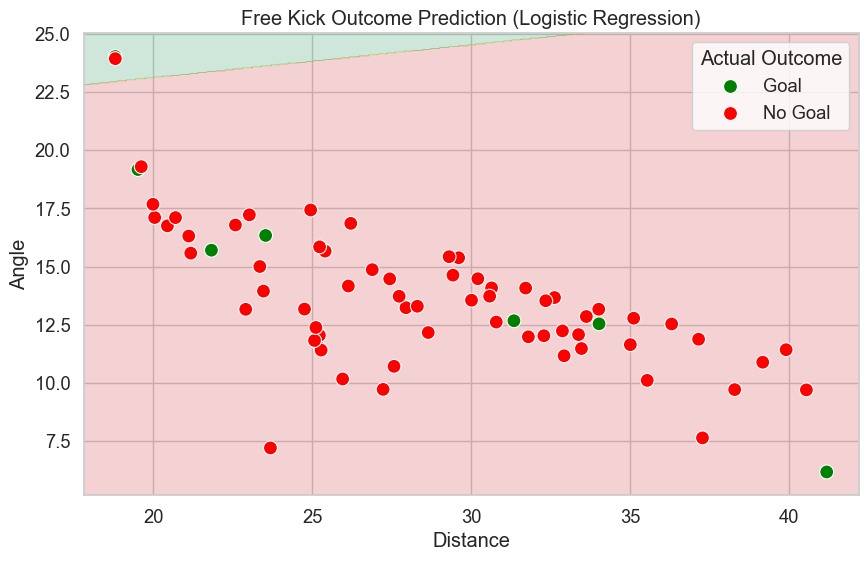